In [4]:
import os
import sys
from jax.config import config
import haiku as hk
import jax
from jax import numpy as jnp
import numpy as onp
import time
from jax.experimental.callback import rewrite
import tqdm

from bnn_hmc import data
from bnn_hmc import models
from bnn_hmc import nn_loss
from bnn_hmc import train_utils
from bnn_hmc import tree_utils
from bnn_hmc import precision_utils
from bnn_hmc import checkpoint_utils
from bnn_hmc import sgmcmc
from jax.experimental import optix
import functools

from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
jax.devices()

In [4]:
# tpu_ip = "10.0.0.2"
# config.FLAGS.jax_xla_backend = "tpu_driver"
# config.FLAGS.jax_backend_target = "grpc://{}:8470".format(tpu_ip)

## 2d Gaussian

In [12]:
mu = jnp.zeros((2,), dtype=jnp.float32)
Sigma = jnp.array([[1., 0.5], [0.5, 1.]])
Sigma_inv = jnp.linalg.inv(Sigma)

def log_prob(x):
    x = x[0]
    return -(x - mu).T @ (Sigma_inv @ (x - mu))

In [26]:
x = [jnp.array([3., 3.])]

total_steps = 1500
lr_schedule = train_utils.make_cosine_lr_schedule(0.1, total_steps)

optimizer = sgmcmc.sgld_gradient_update(lr_schedule, 0)
opt_state = optimizer.init(x)

In [27]:
xs = []
for i in tqdm.tqdm(range(total_steps)):
    grad = jax.grad(log_prob)(x)
    updates, opt_state = optimizer.update(grad, opt_state)
    x = optix.apply_updates(x, updates)
    xs.append(onp.asarray(x))

100%|██████████| 1500/1500 [00:18<00:00, 79.22it/s]


In [28]:
xs = onp.stack(xs, axis=0)[:, 0]

In [29]:
true_samples = onp.random.multivariate_normal(onp.asarray(mu), onp.asarray(Sigma), size=100)

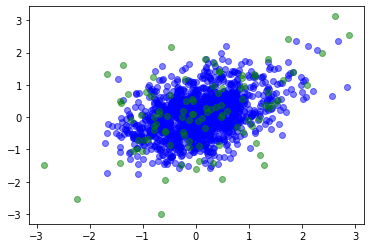

In [30]:
plt.plot(xs[:, 0], xs[:, 1], "bo", alpha=0.5)
plt.plot(true_samples[:, 0], true_samples[:, 1], "go", alpha=0.5)

## Regression example

In [82]:
net_fn = models.make_mlp_regression(layer_dims=[100, 100, 100])
net = hk.transform_with_state(net_fn)
net_apply = net.apply
net_apply = jax.experimental.callback.rewrite(
  net_apply,
  precision_utils.HIGH_PRECISION_RULES)

In [83]:
data_npz = onp.load("synth_reg_data.npz")
x_ = jnp.asarray(data_npz["x_"])
y_ = jnp.asarray(data_npz["y_"])
f_ = jnp.asarray(data_npz["f_"])
x = jnp.asarray(data_npz["x"])
y = jnp.asarray(data_npz["y"])
f = jnp.asarray(data_npz["f"])

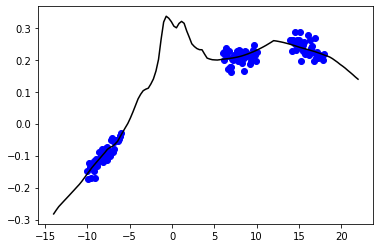

In [84]:
plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")

In [144]:
params, net_state = net.init(jax.random.PRNGKey(0), (f, None), True)

std = 0.005
seed = 1
normal_key = jax.random.PRNGKey(seed)

params, _ = tree_utils.normal_like_tree(params, normal_key)
params = jax.tree_map(lambda p: p * std, params)

In [145]:
noise_std = 0.02
prior_std = 0.1
weight_decay = 1 / prior_std**2

log_prior_fn, log_prior_diff_fn = (
    nn_loss.make_gaussian_log_prior(weight_decay=weight_decay))
log_likelihood_fn = nn_loss.make_gaussian_likelihood(noise_std=noise_std)

In [146]:
num_devices = len(jax.devices())
train_set = (f, y)
test_set = (f_, y_)
train_set = data.pmap_dataset(train_set, num_devices)
test_set = data.pmap_dataset(test_set, num_devices)

net_state = jax.pmap(lambda _: net_state)(jnp.arange(num_devices))

In [195]:
num_epochs = 50000
burnin_epochs = 5000
num_batches = 3
burnin_steps = burnin_epochs * num_batches
total_steps = num_epochs * num_batches
# lr_schedule = train_utils.make_cosine_lr_schedule(7e-8, total_steps)

lr_schedule = train_utils.make_cosine_lr_schedule_with_burnin(1e-7, 5e-8, burnin_steps=burnin_steps)

optimizer = sgmcmc.sgld_gradient_update(lr_schedule, seed)
opt_state = optimizer.init(params)

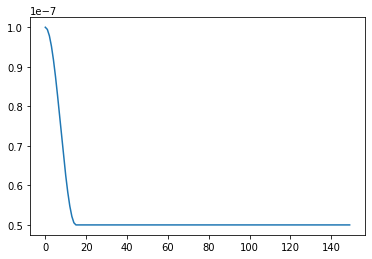

In [196]:
plt.plot([lr_schedule(step) for step in range(0, total_steps, 1000)])

In [148]:
sgd_train_epoch, evaluate = train_utils.make_sgd_train_epoch(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer, num_batches)

In [188]:
jnp.maximum(0, 1)

DeviceArray(1, dtype=int32)

In [149]:
log_prob, mse, likelihood, prior = evaluate(params, net_state, train_set)
log_prob

DeviceArray(-39738.89, dtype=float32)

In [150]:
key = jax.random.PRNGKey(10)
key = jax.random.split(jax.random.PRNGKey(0), num_devices)
all_pred_y_ = []
save_freq = 5000

for iteration in tqdm.tqdm(range(num_epochs)):

    params, net_state, opt_state, logprob_avg, key = sgd_train_epoch(
        params, net_state, opt_state, train_set, key)
    pred_y_, _ = net_apply(params, net_state, None, (f_, None), False)
    all_pred_y_.append(onp.asarray(pred_y_))
    
    if iteration % 1000 == 0:
        print(logprob_avg)
    
    if iteration % save_freq == 0:
        checkpoint_name = "sgld_" + checkpoint_utils.make_checkpoint_name(iteration)
        checkpoint_dict = checkpoint_utils.make_sgd_checkpoint_dict(
            iteration, params, net_state, opt_state, key)
        checkpoint_utils.save_checkpoint(checkpoint_name, checkpoint_dict)

  0%|          | 8/50000 [00:02<21:43:03,  1.56s/it]

-37841.15


  2%|▏         | 1013/50000 [00:19<13:39, 59.81it/s] 

-29082.523


  4%|▍         | 2008/50000 [00:36<13:43, 58.27it/s]

-29325.055


  6%|▌         | 3009/50000 [00:53<13:16, 59.03it/s]

-29494.365


  8%|▊         | 4011/50000 [01:10<13:00, 58.93it/s]

-29627.639


 10%|█         | 5010/50000 [01:27<12:28, 60.08it/s]

-29698.414


 12%|█▏        | 6006/50000 [01:44<12:01, 61.00it/s]

-29802.959


 14%|█▍        | 7009/50000 [02:00<12:03, 59.44it/s]

-29817.172


 16%|█▌        | 8008/50000 [02:17<11:31, 60.76it/s]

-29846.055


 18%|█▊        | 9008/50000 [02:34<12:10, 56.09it/s]

-29899.818


 20%|██        | 10007/50000 [02:51<11:05, 60.10it/s]

-29936.062


 22%|██▏       | 11010/50000 [03:07<10:51, 59.88it/s]

-29921.996


 24%|██▍       | 12013/50000 [03:24<10:32, 60.02it/s]

-29936.662


 26%|██▌       | 13009/50000 [03:41<10:36, 58.10it/s]

-29930.543


 28%|██▊       | 14008/50000 [03:58<09:59, 60.05it/s]

-29940.184


 30%|███       | 15011/50000 [04:15<10:20, 56.35it/s]

-29973.672


 32%|███▏      | 16013/50000 [04:32<09:28, 59.81it/s]

-29946.006


 34%|███▍      | 17012/50000 [04:49<09:17, 59.16it/s]

-29952.484


 36%|███▌      | 18007/50000 [05:05<08:39, 61.60it/s]

-29949.912


 38%|███▊      | 19008/50000 [05:22<08:40, 59.53it/s]

-29939.164


 40%|████      | 20006/50000 [05:38<08:26, 59.26it/s]

-29938.36


 42%|████▏     | 21009/50000 [05:55<07:59, 60.49it/s]

-29930.098


 44%|████▍     | 22010/50000 [06:12<07:32, 61.82it/s]

-29942.662


 46%|████▌     | 23012/50000 [06:28<07:39, 58.76it/s]

-29935.459


 48%|████▊     | 24011/50000 [06:44<07:00, 61.76it/s]

-29956.076


 50%|█████     | 25007/50000 [07:01<06:51, 60.75it/s]

-29921.79


 52%|█████▏    | 26007/50000 [07:17<06:35, 60.65it/s]

-29921.184


 54%|█████▍    | 27010/50000 [07:34<06:32, 58.51it/s]

-29906.092


 56%|█████▌    | 28013/50000 [07:51<05:51, 62.56it/s]

-29919.984


 58%|█████▊    | 29007/50000 [08:07<05:37, 62.28it/s]

-29914.332


 60%|██████    | 30009/50000 [08:24<05:25, 61.48it/s]

-29906.016


 62%|██████▏   | 31009/50000 [08:40<05:02, 62.85it/s]

-29913.148


 64%|██████▍   | 32010/50000 [08:56<04:50, 61.99it/s]

-29920.66


 66%|██████▌   | 33009/50000 [09:12<04:31, 62.56it/s]

-29912.2


 68%|██████▊   | 34013/50000 [09:28<04:17, 62.08it/s]

-29913.176


 70%|███████   | 35007/50000 [09:44<04:06, 60.77it/s]

-29939.516


 72%|███████▏  | 36008/50000 [10:00<03:46, 61.84it/s]

-29917.318


 74%|███████▍  | 37009/50000 [10:17<03:25, 63.12it/s]

-29923.02


 76%|███████▌  | 38011/50000 [10:33<03:16, 61.14it/s]

-29922.738


 78%|███████▊  | 39007/50000 [10:49<02:54, 62.90it/s]

-29923.975


 80%|████████  | 40013/50000 [11:05<02:39, 62.57it/s]

-29925.922


 82%|████████▏ | 41012/50000 [11:22<02:25, 61.87it/s]

-29925.037


 84%|████████▍ | 42010/50000 [11:38<02:13, 59.69it/s]

-29934.05


 86%|████████▌ | 43011/50000 [11:54<01:51, 62.75it/s]

-29930.613


 88%|████████▊ | 44012/50000 [12:11<01:39, 60.33it/s]

-29929.246


 90%|█████████ | 45006/50000 [12:27<01:22, 60.48it/s]

-29932.74


 92%|█████████▏| 46013/50000 [12:43<01:04, 62.05it/s]

-29930.21


 94%|█████████▍| 47012/50000 [13:00<00:49, 60.10it/s]

-29930.014


 96%|█████████▌| 48007/50000 [13:16<00:32, 61.47it/s]

-29929.762


 98%|█████████▊| 49008/50000 [13:32<00:16, 60.18it/s]

-29929.896


100%|██████████| 50000/50000 [13:48<00:00, 60.34it/s]


In [154]:
all_pred_y_stack_ = onp.concatenate([preds[None, :, 0] for preds in all_pred_y_])

In [161]:
all_pred_y_stack_ = all_pred_y_stack_[500:-100]

In [163]:
all_pred_y_stack_

array([[-0.24906375, -0.2401471 , -0.23131059, ...,  0.24973479,
         0.24963957,  0.24935462],
       [-0.30740163, -0.29570174, -0.2841875 , ...,  0.2031494 ,
         0.20139953,  0.19962111],
       [-0.30695668, -0.2952777 , -0.2836328 , ...,  0.20153132,
         0.19965123,  0.19785744],
       ...,
       [-0.28585213, -0.27563894, -0.26546317, ...,  0.15338281,
         0.14774619,  0.14213905],
       [-0.28588128, -0.27567148, -0.26548254, ...,  0.1533798 ,
         0.14774188,  0.1421334 ],
       [-0.28581387, -0.2756157 , -0.26542866, ...,  0.15340751,
         0.14777353,  0.14216056]], dtype=float32)

In [164]:
pred_mean = onp.mean(all_pred_y_stack_, axis=0)
pred_std = onp.std(all_pred_y_stack_, axis=0)

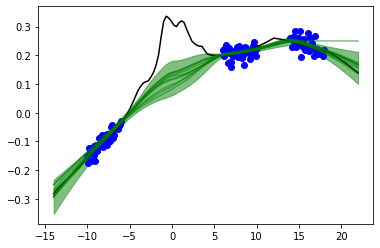

In [165]:
pred_y_, _ = net_apply(params, net_state, None, (f_, None), False)
plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")
plt.fill_between(x_, pred_mean + 3*pred_std, pred_mean - 3*pred_std, color="g", alpha=0.5)
plt.plot(x_, all_pred_y_[-1], "--g")
for preds in all_pred_y_stack_[::5000]:
    plt.plot(x_, preds, alpha=0.5, color="g")

In [166]:
# onp.savez("sgld_predictive_2.npz", preds=all_pred_y_stack_)

## Compare two chains

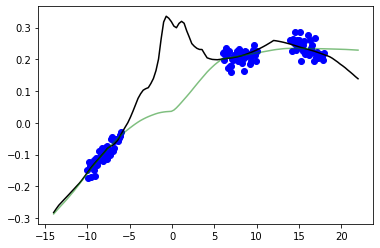

In [169]:
all_pred_y_stack_ = onp.load("sgld_predictive_1.npz")["preds"]
pred_mean = onp.mean(all_pred_y_stack_, axis=0)
pred_std = onp.std(all_pred_y_stack_, axis=0)

plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")
plt.fill_between(x_, pred_mean + 3*pred_std, pred_mean - 3*pred_std, color="g", alpha=0.3)
for preds in all_pred_y_stack_[::5000]:
    plt.plot(x_, preds, alpha=0.5, color="g")

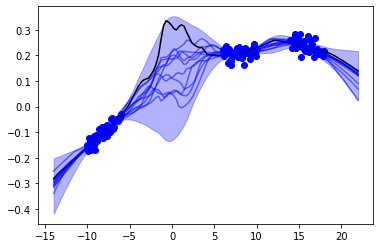

In [104]:
all_pred_y_stack_ = onp.load("predictive_0.npz")["preds"]
pred_mean = onp.mean(all_pred_y_stack_, axis=0)
pred_std = onp.std(all_pred_y_stack_, axis=0)

plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")
plt.fill_between(x_, pred_mean + 3*pred_std, pred_mean - 3*pred_std, color="b", alpha=0.3)
for preds in all_pred_y_stack_[::20]:
    plt.plot(x_, preds, alpha=0.5, color="b")

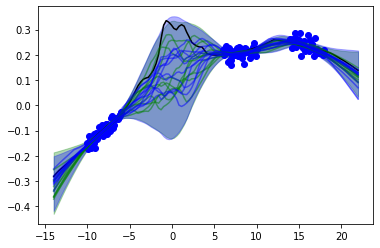

In [105]:
all_pred_y_stack_ = onp.load("predictive_1.npz")["preds"]
pred_mean = onp.mean(all_pred_y_stack_, axis=0)
pred_std = onp.std(all_pred_y_stack_, axis=0)

plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")
plt.fill_between(x_, pred_mean + 3*pred_std, pred_mean - 3*pred_std, color="g", alpha=0.3)
for preds in all_pred_y_stack_[::20]:
    plt.plot(x_, preds, alpha=0.5, color="g")
    
    all_pred_y_stack_ = onp.load("predictive_0.npz")["preds"]
pred_mean = onp.mean(all_pred_y_stack_, axis=0)
pred_std = onp.std(all_pred_y_stack_, axis=0)

plt.fill_between(x_, pred_mean + 3*pred_std, pred_mean - 3*pred_std, color="b", alpha=0.3)
for preds in all_pred_y_stack_[::20]:
    plt.plot(x_, preds, alpha=0.5, color="b")

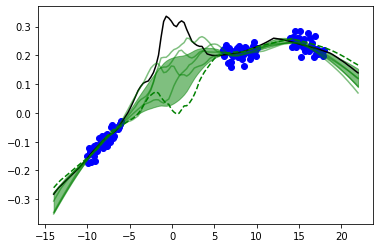

In [68]:
pred_y_, _ = net_apply(params, net_state, None, (f_, None), False)
plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")
plt.fill_between(x_, pred_mean + pred_std, pred_mean - pred_std, color="g", alpha=0.5)
plt.plot(x_, all_pred_y_[-1], "--g")
for preds in all_pred_y_stack_[::50]:
    plt.plot(x_, preds, alpha=0.5, color="g")

In [70]:
# onp.savez("predictive_1.npz", preds=all_pred_y_stack_)
# onp.savez("predictive_0.npz", preds=all_pred_y_stack_)

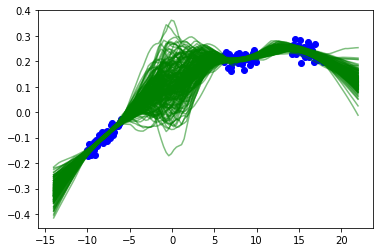

In [69]:
pred_y_, _ = net_apply(params, net_state, None, (f_, None), False)
plt.plot(x, y, "bo")
# plt.fill_between(x_, pred_mean + pred_std, pred_mean - pred_std, color="g", alpha=0.5)
for preds in all_pred_y_stack_[::1]:
    plt.plot(x_, preds, alpha=0.5, color="g")

## Loss Surface

In [176]:
def tree_diff(a, b):
    return jax.tree_multimap(lambda p_a, p_b: p_a - p_b, a, b)
def tree_norm(a):
    return float(jnp.sqrt(sum([jnp.sum(p_a**2) for p_a in jax.tree_leaves(a)])))
    
def get_u_v_o(params1, params2, params3):
    
#     print([p.shape for p in jax.tree_leaves(params1)])
    
    u_params = tree_diff(params2, params1)
    u_norm = tree_norm(u_params)
    u_params = tree_utils.tree_scalarmul(u_params, 1 / u_norm)
    v_params = tree_diff(params3, params1)
    uv_dot = tree_utils.tree_dot(u_params, v_params)
    v_params = jax.tree_multimap(lambda v, u: v - uv_dot * u, v_params, u_params)
    v_norm = tree_norm(v_params)
    v_params = tree_utils.tree_scalarmul(v_params, 1 / v_norm)
    
    return u_params, u_norm, v_params, v_norm, params1

In [181]:
checkpoint_dict = checkpoint_utils.load_checkpoint("sgld_model_step_5000.pt")
params1 = checkpoint_dict["params"]

checkpoint_dict = checkpoint_utils.load_checkpoint("sgld_model_step_15000.pt")
params2 = checkpoint_dict["params"]

checkpoint_dict = checkpoint_utils.load_checkpoint("sgld_model_step_40000.pt")
params3 = checkpoint_dict["params"]

In [182]:
for params in [params1, params2, params3]:
    log_prob, _, _, _ = evaluate(params, net_state, train_set)
    print(log_prob)

-29698.021
-29939.787
-29925.355


In [183]:
u_params, u_norm, v_params, v_norm, o_params = get_u_v_o(params1, params2, params3)

u_ts = onp.linspace(-.25, 1.25, 40)
v_ts = onp.linspace(-.25, 1.25, 40)
n_u, n_v = len(u_ts), len(v_ts)
log_probs = onp.zeros((n_u, n_v))
grid = onp.zeros((n_u, n_v, 2))

for u_i, u_t in enumerate(tqdm.tqdm(u_ts)):
    for v_i, v_t in enumerate(v_ts):
        grid[u_i, v_i] = [u_t, v_t]
        params = jax.tree_multimap(lambda u, v, o: o + u * u_t * u_norm + v * v_t * v_norm, 
                                   u_params, v_params, o_params)
        log_prob, _, _, _ = evaluate(params, net_state, train_set)
        log_probs[u_i, v_i] = float(log_prob)

100%|██████████| 40/40 [00:20<00:00,  1.95it/s]


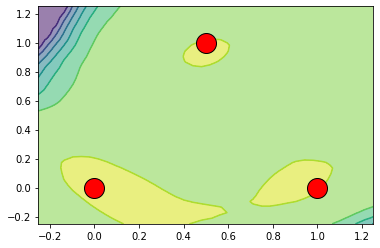

In [184]:
log_probs_cliped = onp.clip(log_probs, -7.e4, 0)
plt.contour(grid[:, :, 0], grid[:, :, 1], log_probs_cliped, zorder=1)
plt.contourf(grid[:, :, 0], grid[:, :, 1], log_probs_cliped, zorder=0, alpha=0.55)
plt.plot([0., 1., 0.5], [0., 0., 1.], "ro", ms=20, markeredgecolor="k")

## Distance analysis

In [185]:
checkpoint_dict = checkpoint_utils.load_checkpoint("sgld_model_step_5000.pt")
params1 = checkpoint_dict["params"]

checkpoint_dict = checkpoint_utils.load_checkpoint("sgld_model_step_40000.pt")
params2 = checkpoint_dict["params"]

In [186]:
d = sum([jnp.size(p) for p in jax.tree_leaves(params1)])
theory_dist = jnp.sqrt(2 * d * prior_std**2)

dist = tree_norm(tree_diff(params2, params1))
print(dist, theory_dist)

6.747331142425537 20.298277


In [187]:
a,b,c = zip(*[[1, "a", 0.1], [2, "b", 0.2], [3, "c", 0.3]])